In [37]:
import pickle
from pathlib import Path
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score as AMI, normalized_mutual_info_score as NMI

In [4]:
paths = list(Path("../databases/CATH0").glob("*.npz"))
names = [p.stem for p in paths]

emats = dict(zip(names, map(np.load, paths)))

In [6]:
emats.keys()

dict_keys(['64-128-128-256__LH__T6__Pmax', '64-128-128-256__L0__T6__Pmax', '64-128-128-256__LT__T6__Pmax', '64-128-128-256__LC__T6__Pmax', '64-128-128-256__L0__T6__Pconcat', '64-128-128-256__LC__T6__Pconcat', '64-128-128-256__LA__T6__Pconcat', '128-128-128-128__LA__T6__Pmax', '128-128-128-128__LT__T6__Pmax', '128-128-128-128__LT__T6__Pconcat', '128-128-128-128__LC__T6__Psum', '64-128-128-256__LT__T6__Pconcat', '128-128-128-128__L0__T6__Psum', '64-128-128-256__LH__T6__Pconcat', '128-128-128-128__LA__T6__Pconcat', '64-128-128-256__LC__T6__Psum', '64-128-128-256__L0__T6__Psum', '64-128-128-256__LT__T6__Psum', '64-128-128-256__LA__T6__Pmax', '128-128-128-128__L0__T6__Pconcat', '64-128-128-256__LA__T6__Psum', '128-128-128-128__LH__T6__Pmax', '128-128-128-128__LC__T6__Pmax', '128-128-128-128__LC__T6__Pconcat', '128-128-128-128__LH__T6__Pconcat', '128-128-128-128__LT__T6__Psum', '64-128-128-256__LH__T6__Psum', '128-128-128-128__L0__T6__Pmax', '128-128-128-128__LA__T6__Psum', '128-128-128-128_

In [5]:
cath_annotation_frame = pd.read_table("../data/domain-classifications.tsv")

In [59]:
n_on_target = 500
nrand       = 1000

classes = {'C': 'CLASS', 'A': 'ARCH', 'T': 'TOPOL', 'H': 'HOMOL', '0': 'Vanilla'}

def get_points(subframe, avail_ids, source_mat, sample_size=None):
    domains = set(subframe.DOMAIN.values) & set(avail_ids)
    domains  = np.array(list(domains))
    
    if sample_size is not None:
        domains  = domains[np.random.choice(range(len(domains)), size=sample_size)]
    
    pts = np.array([source_mat[i] for i in range(len(avail_ids)) if ids[i] in domains])
    dom = [ids[i] for i in range(len(avail_ids)) if ids[i] in domains]
    return pts, dom


def model_name(filter_string):
    order = []
    counts = defaultdict(int)
    for f in map(int, filter_string.split("-")):
        if f not in order:
            order.append(f)
        counts[f] += 1
    
    components = []
    for filt in order:
        components.append(f"{filt}x{counts[filt]}")
    return "-".join(components)

def retrieve_info(result, cluster_hue, k):
    R   = result['R']
    frame = cath_annotation_frame[cath_annotation_frame.DOMAIN.isin(result['id'])]    
    
    vc  = frame[cluster_hue].value_counts().sort_values(ascending=False)
    top = vc.index[:k]
    
    return R, ids, frame, top

In [60]:
rows = []

{'nmi': 0.25365178553751516, 'ami': 0.25003343070709133, 'arch': '128-128-128-128', 'level': 'C', 'pooling': 'max', 'cluster_hue': 'HOMOL'}
{'nmi': 0.12181305551848051, 'ami': 0.11694270052493486, 'arch': '128-128-128-128', 'level': 'C', 'pooling': 'concat', 'cluster_hue': 'HOMOL'}
{'nmi': 0.18808383045428156, 'ami': 0.18373206835486394, 'arch': '128-128-128-128', 'level': 'C', 'pooling': 'sum', 'cluster_hue': 'HOMOL'}
{'nmi': 0.2443835356322654, 'ami': 0.24024418565684075, 'arch': '64-128-128-256', 'level': 'C', 'pooling': 'max', 'cluster_hue': 'HOMOL'}
{'nmi': 0.024371183243118072, 'ami': 0.018297525864967024, 'arch': '64-128-128-256', 'level': 'C', 'pooling': 'concat', 'cluster_hue': 'HOMOL'}
{'nmi': 0.22027063942525263, 'ami': 0.2163089596698466, 'arch': '64-128-128-256', 'level': 'C', 'pooling': 'sum', 'cluster_hue': 'HOMOL'}
{'nmi': 0.24657214216883402, 'ami': 0.24296067065981836, 'arch': '128-128-128-128', 'level': 'A', 'pooling': 'max', 'cluster_hue': 'HOMOL'}
{'nmi': 0.0615441

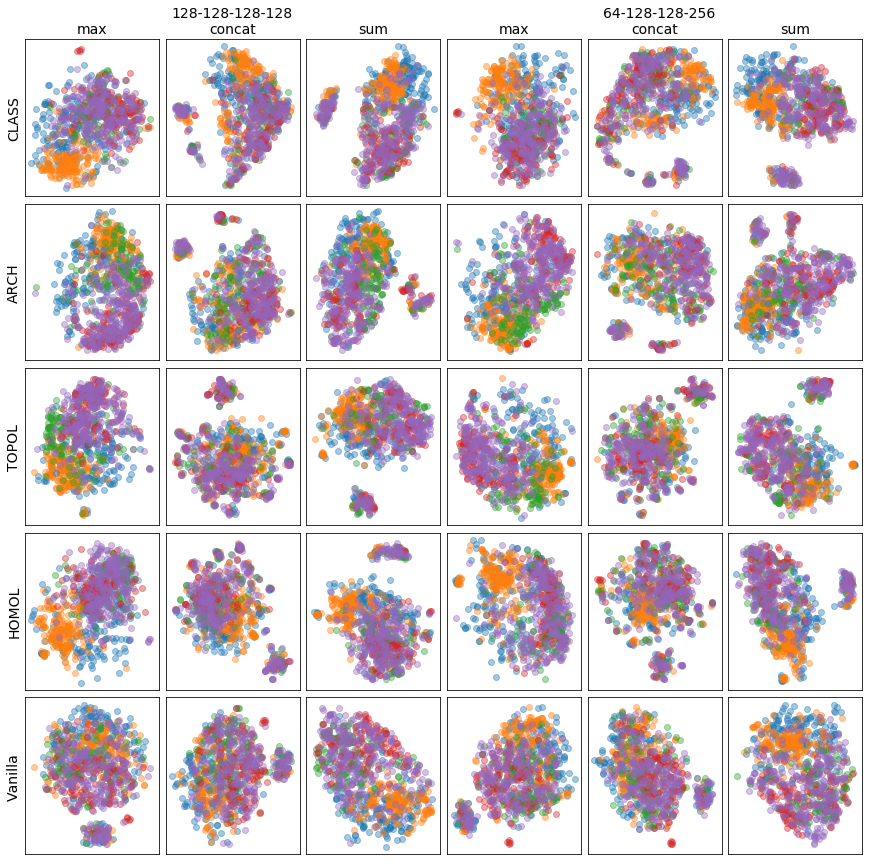

In [79]:
template = "{architecture}__L{level}__T6__P{pool}"
architectures = ['128-128-128-128', '64-128-128-256']

pooling       = ['max', 'concat', 'sum']
cluster_hue   = 'HOMOL'
k = 5

fig, axarr = plt.subplots(len(levels), len(pooling)*len(architectures), figsize=(15, 15))

fig.text(0.26, 0.9, architectures[0], fontsize=14)
fig.text(0.66, 0.9, architectures[1], fontsize=14)

for row, level in enumerate(levels):
    axarr[row, 0].set_ylabel(classes[level], fontsize=14)
    for semi, arch in enumerate(architectures):
        axes = axarr[row, len(pooling)*semi:(len(pooling)*semi)+len(pooling)]

        for ax, pool in zip(axes, pooling):
            ax.set_xticks([]); ax.set_yticks([])
            key = template.format(architecture=arch, level=level, pool=pool)
            result = emats[key]
            ids = result['id']

            R   = result['R']
            
            frame = cath_annotation_frame[cath_annotation_frame.DOMAIN.isin(ids)]
            vc    = frame[cluster_hue].value_counts().sort_values(ascending=False)
            top   = vc.index[:k]
            
            hue_frame = frame[frame[cluster_hue].isin(top)]
            for category, group in hue_frame.groupby(cluster_hue):
                rxy, _ = get_points(group, ids, R, n_on_target)
                rx, ry = zip(*rxy)
                ax.scatter(rx, ry, label=category, alpha=0.4)
                
            all_samples, all_domains = get_points(hue_frame, ids, result['E'])
            lbl_map = dict(hue_frame[['DOMAIN', cluster_hue]].values)
            types   = hue_frame[cluster_hue].unique()
            map_    = dict(zip(types, range(len(types))))
            
            actual = [map_[lbl_map[d]] for d in all_domains]
            
            kme = KMeans(n_clusters=k).fit(all_samples)
            rows.append(dict(nmi=NMI(actual, kme.labels_),
                             ami=AMI(actual, kme.labels_),
                             arch=arch,
                             level=level,
                             pooling=pool,
                             cluster_hue=cluster_hue))
            print(rows[-1])

for i, colax in enumerate(axarr[0]):
    title = dict(zip(range(len(pooling)), pooling))[i % len(pooling)]
    colax.set_title(title, fontsize=14)
    
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.savefig(f"figs/architecture_search__hue-{cluster_hue}__top-{k}.png")

In [77]:
cluster_frame = pd.DataFrame(rows).drop_duplicates(['arch', 'level', 'pooling', 'cluster_hue'])
cluster_frame = cluster_frame.sort_values(by='nmi', ascending=False).reset_index()
cluster_frame.loc[:5]

,index,nmi,ami,arch,level,pooling,cluster_hue
0,24,0.370560,0.369051,64-128-128-256,H,max,TOPOL
1,12,0.361475,0.359914,64-128-128-256,A,max,TOPOL
2,21,0.358619,0.357081,128-128-128-128,H,max,TOPOL
3,15,0.345496,0.343917,128-128-128-128,T,max,TOPOL
4,9,0.315173,0.313501,128-128-128-128,A,max,TOPOL
5,18,0.314842,0.313192,64-128-128-256,T,max,TOPOL


In [330]:
#M = 2000

classes = {'C': 'CLASS', 'A': 'ARCH'}
thresholds = [4, 6, 8, 10]
architectures = sorted(set(em.split("__")[0] for em in emats), key=lambda x: sum(map(int, x.split("-"))))[:]
print(architectures)

# underlying model clustered either C or A
classifier = 'C' 
cluster_hue = 'CLASS'
k   = 5
nrand = 500
n_on_target = 500

def get_points(subframe, avail_ids, source_mat, sample_size=None):
    domains = set(subframe.DOMAIN.values) & set(avail_ids)
    domains  = np.array(list(domains))
    
    if sample_size is not None:
        domains  = domains[np.random.choice(range(len(domains)), size=sample_size)]
    
    rx, ry = zip(*[source_mat[i] for i in range(len(avail_ids)) if ids[i] in domains])
    return rx, ry

def model_name(filter_string):
    order = []
    counts = defaultdict(int)
    for f in map(int, filter_string.split("-")):
        if f not in order:
            order.append(f)
        counts[f] += 1
    
    components = []
    for filt in order:
        components.append(f"{filt}x{counts[filt]}")
    return "-".join(components)

def retrieve_info(result, cluster_hue, k):
    R   = result['R']
    frame = cath_annotation_frame[cath_annotation_frame.DOMAIN.isin(result['id'])]    
    
    vc  = frame[cluster_hue].value_counts().sort_values(ascending=False)
    top = vc.index[:k]
    
    return R, ids, frame, top

['128-128-128-128', '64-128-128-256']


In [12]:
fig, axarr = plt.subplots(len(thresholds), len(architectures), figsize=(6.4, 4.8))

# underlying model had classification task on following CATH level:
classifier  = 'A'
cluster_hue = 'TOPOL' # color clusters by this field
for row, t in enumerate(thresholds):
    axarr[row, 0].set_ylabel(f"$t={t}$")
    for col, arch in enumerate(architectures):
        title = model_name(arch)
        name  = f"{arch}__L{classifier}__T{t}"
        axarr[0, col].set_title(title)
        result = emats[name]
        
        # all reduced points
        R   = result['R']
        ids = result['id']
        
        frame = cath_annotation_frame[cath_annotation_frame.DOMAIN.isin(ids)]
        vc    = frame[cluster_hue].value_counts().sort_values(ascending=False)
        top   = vc.index[:k]
        
        for category, group in frame[frame[cluster_hue].isin(top)].groupby(cluster_hue):
            rx, ry = get_points(group, ids, R, sample_size=n_on_target)
            axarr[row, col].scatter(rx, ry, label=category, alpha=0.4)
    
plt.legend(bbox_to_anchor=(1, 1.25))
plt.show()

NameError: name 'thresholds' is not defined

KeyboardInterrupt: 

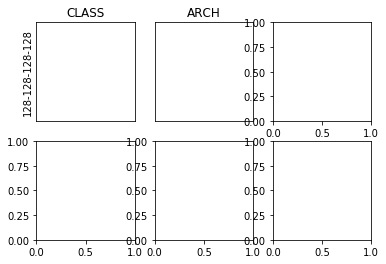

In [332]:
architectures = ['128-128-128-128', '64-128-128-256']
threshold     = 6
clfs          = ['C', 'A', 'T']

map_ = dict(C="CLASS", A="ARCH", T="TOPOL", H="HOMOL")

cluster_hue = "ARCH"
k = 6

fig, axarr = plt.subplots(len(architectures), len(clfs))
for row, arch in enumerate(architectures):
    axarr[row, 0].set_ylabel(arch)
    for col, cls in enumerate(clfs):
        axarr[0, col].set_title(map_[cls])
        key = f"{arch}__L{cls}__T{threshold}"
        
        axarr[row, col].set_xticks([])
        axarr[row, col].set_yticks([])
        
        R, ids, frame, topk = retrieve_info(emats[key], cluster_hue, k)

IndexError: too many indices for array

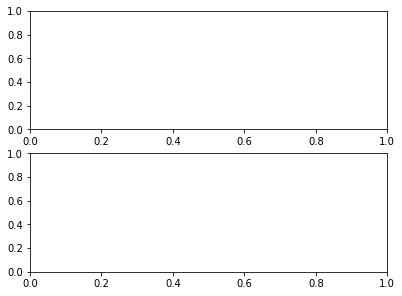

In [328]:
architecture = "128-128-128-128"
thresholds = [6]
clfs = ['C', 'A']
cluster_hue = 'ARCH'
k = 6

fig, axarr = plt.subplots(len(clfs), len(thresholds), figsize=(6.4, 4.8))
frames = []
for row, cls in enumerate(clfs):
    axarr[row, 0].set_ylabel({"C": "CLASS", "A": "ARCH"}[cls])
    for col, t in enumerate(thresholds):
        axarr[0, col].set_title(f"$t={t}$")
        key = f"{architecture}__L{cls}__T{t}"
        result = emats[key]
        R = result['R']
        ids = result['id']
        frame = cath_annotation_frame[cath_annotation_frame.DOMAIN.isin(ids)]
        
        ids = [i for i in ids if i in frame.DOMAIN.values]
        
        vc = frame[cluster_hue].value_counts().sort_values(ascending=False)
        top = vc.index[:k]
        
        axarr[row, col].set_xticks([])
        axarr[row, col].set_yticks([])
        
        eframe = frame[frame[cluster_hue].isin(top)]
        result_ids = dict(map(list, map(reversed, enumerate(ids))))
        
        embs = []
        for i in ids:
            idx = result_ids[i]
            embs.append(result['R'][idx])
            
        km = KMeans(n_clusters=k).fit(embs)
        clusters = km.labels_
        
        dom2label = dict(frame[['DOMAIN', cluster_hue]].values)
        linds = sorted(set(dom2label.values()))
        l2idx = dict(zip(linds, range(len(linds))))
        actual = [l2idx[dom2label[i]] for i in ids]
        print(f"{cls} {t} kmeans ami={ami(actual, clusters)}, nmi={nmi(actual, clusters)}")

        for category, group in frame[frame[cluster_hue].isin(top)].groupby(cluster_hue):
            rx, ry = get_points(group, ids, R, sample_size=n_on_target)
            axarr[row, col].scatter(rx, ry, label=category, alpha=0.4)
            
lgnd = plt.legend(bbox_to_anchor=(0.9, 0.0), ncol=2)
plt.savefig(f"figs/TSNE_multitaskers_hue-{cluster_hue}.png", bbox_inches='tight')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for lh in lgnd.legendHandles:
    lh.set_alpha(1)
plt.show()

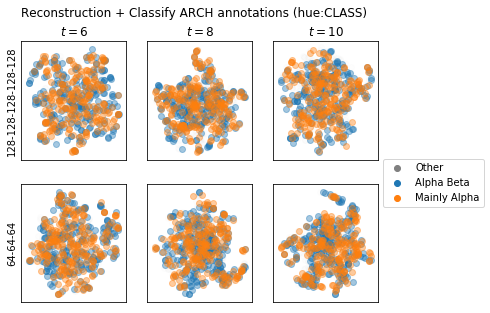

In [132]:
fig, axarr = plt.subplots(2, 3, figsize=(6.4, 4.8))
#axarr = axarr[None, :]
fig.suptitle(f"Reconstruction + Classify {classes[classifier]} annotations (hue:{cluster_hue})")

for j, threshold in enumerate(thresholds):
    axarr[0, j].set_title(f"$t = {threshold}$")
    for i, arch in enumerate(architectures):
        axarr[i, 0].set_ylabel(arch)
        em = f"{arch}__L{classifier}__T{threshold}"
        R = reductions[em]['R']
        ids = np.array(reductions[em]['id'])
        frame = cath_annotation_frame[cath_annotation_frame.DOMAIN.isin(ids)]
        vc = frame[cluster_hue].value_counts().sort_values(ascending=False)
        top = vc.index[:k]
    
        if not frame[~frame[cluster_hue].isin(top)].empty:
            rx, ry = get_points(nrand, frame[~frame[cluster_hue].isin(top)], ids, R)
            axarr[i, j].scatter(rx, ry, label='Other', alpha=0.01, color='grey')

        for category, group in frame[frame[cluster_hue].isin(top)].groupby(cluster_hue):
            rx, ry = get_points(n_on_target, group, ids, R)
            axarr[i, j].scatter(rx, ry, label=category, alpha=0.4)
      
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
        #ax.set_title()
lgnd = plt.legend(bbox_to_anchor=(1, 1.25))

for lh in lgnd.legendHandles:
    lh.set_alpha(1)
plt.show()

In [138]:
reductions['64-128-128-256__LA__T6']['E'][0].shape

(576,)

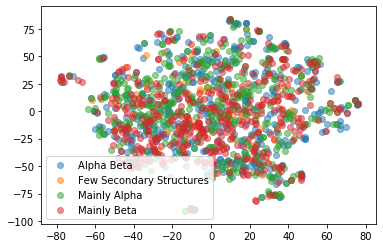

In [92]:
key = '128-128-128-128-128__LC__T10'
ids = reductions[key]['id']
cluster_hue = "CLASS"
k=4

frame = cath_annotation_frame[cath_annotation_frame.DOMAIN.isin(ids)]
vc = frame[cluster_hue].value_counts().sort_values(ascending=False)
top = vc.index[:k]
R = reductions[key]['R']
    
if not frame[~frame[cluster_hue].isin(top)].empty:
    rx, ry = get_points(nrand, frame[~frame[cluster_hue].isin(top)], ids, R)
    plt.scatter(rx, ry, label='Other', alpha=0.5, color='grey')

for category, group in frame[frame[cluster_hue].isin(top)].groupby(cluster_hue):
    rx, ry = get_points(n_on_target, group, ids, R)
    plt.scatter(rx, ry, label=category, alpha=0.5)
    
plt.legend()

# Loss curves

In [172]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

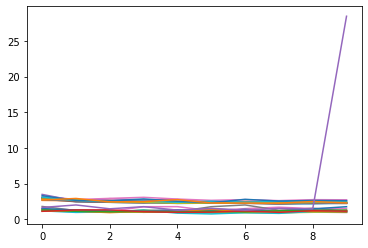

In [175]:
all_losses = Path("../results/multitask/max/").rglob("loss.tsv")
map_ = {"C": "CLASS", "A": "ARCH"}

rows = []
columns = ['model_architecture', 'model_classification_task', 'loss_path', 'alias']

info2loss = dict()
for filename in all_losses:
    info = filename.parent.stem
    astring, level, threshold = info.split("__")
    level = level[1:]
    threshold = int(threshold[1:])
    
    loss_history = pd.read_table(filename)
    info2loss[info] = loss_history
    rows.append(dict(zip(columns, (astring, map_[level], threshold, filename, info))))
    

loss_frame = pd.DataFrame(rows)
for model in info2loss:
    plt.plot(info2loss[model].val.values, label=model)
#plt.legend()
plt.show()

,epoch,train,val
0,0,1.415116,1.797850
1,1,1.233763,1.227385
2,2,1.183873,1.248314
3,3,1.045795,1.018328
4,4,0.989650,1.069915
5,5,0.974132,1.764822
6,6,0.870929,2.011805
7,7,0.859678,1.266155
8,8,0.815934,1.545284
9,9,0.764237,1.138829
